# Testing Naive Bayes and LinearSVC

In this notebook, we use a method of supervised learning to attempt and classify patents into predefined categories. To begin, we load in the data, then preprocess it. As patent classifications can be very niche, we combined the ipc_section and ipc_class into one column. We addtionally subset to only predict with classes that have more than fifty observations. Overall, the goal is to predict this classification based on the patent title and abstract.

In [2]:
# Load in libraries and data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import re
import math
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")


df = pd.read_csv(
    "/Users/lilahduboff/Documents/Duke NLP/Final Project/Natural_Language_Processing_Final_Project/Data/subsidiary_patents.csv"
)

# check the length, may need git lfs
df.shape

(99106, 13)

In [3]:
df.sample(20)

,SYMBOL,SUBSIDIARY,patent_id,patent_title,patent_date,patent_year,patent_type,withdrawn,assignee_organization,ipc_sections,ipc_classes,ipc_subclasses,patent_abstract
90930,HON,UOP LLC,11837767,Electrolyte compositions for redox flow batteries,2023-12-05,2023,utility,False,UOP LLC,H,1,M,Stable and high performance positive and negat...
77180,VZ,Verizon Patent and Licensing Inc.,12334048,Systems and methods for reconstructing voice p...,2025-06-17,2025,utility,False,Verizon Patent and Licensing Inc.,G,10;6,F;L,A device may receive and convert audio data to...
46746,NKE,Nike Inc.,D830037,Garment,2018-10-09,2018,design,False,"NIKE, Inc.",NaN,NaN,NaN,NaN
99079,V,CardinalCommerce,7797731,Centralized identity authentication for electr...,2010-09-14,2010,utility,False,CardinalCommerce Corporation,H,04,L,A method of centralized identity authenticatio...
50002,PG,Proctor & Gamble,6844305,Aqueous liquid detergent compositions comprisi...,2005-01-18,2005,utility,False,THE PROCTOR & GAMBLE COMPANY,C,11,D,The present invention relates to aqueous liqui...
3187,CVX,Texaco Inc.,3953322,Non-catalytic process for treating naphtha con...,1976-04-27,1976,utility,False,Texaco Inc.,C,10,G,A naphtha is treated by heating in the presenc...
28429,MRK,"Merck & Co., Inc.",4755508,Benzodiazepine analogs and use as antogonists ...,1988-07-05,1988,utility,False,"MERCK & CO., INC.",A;C,07;61,D;K,Benzodiazepines of the formula: ##STR1## are d...
97697,MSFT,"Nuance Communications, Inc.",7848314,VOIP barge-in support for half-duplex DSR clie...,2010-12-07,2010,utility,False,"Nuance Communications, Inc.",H,04,L,Providing VOIP barge-in support for a half-dup...
23874,JNJ,Ethicon,9220526,Rotational coupling device for surgical instru...,2015-12-29,2015,utility,False,"Ethicon Endo-Surgery, Inc.",A;F,16;61,B;C,Rotational couplers for use with surgical devi...
36612,NKE,Nike Inc.,11317681,Automated identification of shoe parts,2022-05-03,2022,utility,False,"NIKE, Inc.",A;B;G,25;43;6,D;J;T,Manufacturing of a shoe or a portion of a shoe...


## Basic EDA and adjustments to data

In this section, I will check for missing values, explore and modify data types, and save a subset with the 500 most recent patents to a new csv for further preprocessing 

In [4]:
# See how many rows are null
# if the abstract is null, we can't use it for classification
print(df["patent_abstract"].isnull().sum())

16304


In [5]:
# drop rows with null abstracts
df = df.dropna(subset=["patent_abstract"])

In [6]:
# likely will need to convert some datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82802 entries, 0 to 99105
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   SYMBOL                 82802 non-null  object
 1   SUBSIDIARY             82802 non-null  object
 2   patent_id              82802 non-null  object
 3   patent_title           82802 non-null  object
 4   patent_date            82802 non-null  object
 5   patent_year            82802 non-null  int64 
 6   patent_type            82802 non-null  object
 7   withdrawn              82802 non-null  bool  
 8   assignee_organization  82802 non-null  object
 9   ipc_sections           82782 non-null  object
 10  ipc_classes            82782 non-null  object
 11  ipc_subclasses         82782 non-null  object
 12  patent_abstract        82802 non-null  object
dtypes: bool(1), int64(1), object(11)
memory usage: 8.3+ MB


In [7]:
# converting patent date to datetime so we can use it to filter
df["patent_date"] = pd.to_datetime(df["patent_date"], errors="coerce")

In [8]:
# select the most recent 500 patents for each subsidiary

df = df.sort_values(["SUBSIDIARY", "patent_date"], ascending=[True, False])
top500_subset = df.groupby("SUBSIDIARY").head(500)

top500_subset.shape

(21644, 13)

In [9]:
# brief look at the subset
top500_subset.head()

,SYMBOL,SUBSIDIARY,patent_id,patent_title,patent_date,patent_year,patent_type,withdrawn,assignee_organization,ipc_sections,ipc_classes,ipc_subclasses,patent_abstract
25759,MMM,"3M COGENT, INC.",8411916,Bio-reader device with ticket identification,2013-04-02,2013,utility,False,"3M Cogent, Inc.",G,06,K,A method and device for determining a concentr...
25758,MMM,"3M COGENT, INC.",8379982,System and method for fast biometric pattern m...,2013-02-19,2013,utility,False,"3M Cogent, Inc.",G,06,K,A method and system for matching two biometric...
25757,MMM,"3M COGENT, INC.",8275179,Apparatus for capturing a high quality image o...,2012-09-25,2012,utility,False,"3M Cogent, Inc.",G,06,K,An apparatus for capturing the image of a wet/...
25756,MMM,"3M COGENT, INC.",8254728,Method and apparatus for two dimensional image...,2012-08-28,2012,utility,False,"3M Cogent, Inc.",G,06,K,"In one embodiment, the present invention is a ..."
25755,MMM,"3M COGENT, INC.",8131477,Method and device for image-based biological d...,2012-03-06,2012,utility,False,"3M Cogent, Inc.",G,01;06,F;K;N,A device and method for determining a concentr...


In [10]:
# export to data folder
top500_subset.to_csv("data/top500_patents.csv", index=False)

## Actual Preprocessing
Now that we have our finalized data, we will combine the section and class columns, as well as the title and abstract columns, to simplify our predictions. We will also drop any patents classifications that have under 50 observations. As patent classifications have be very niche, we expect to see many patents that have multiple classifications but only 1-2 observations. This doesn't typically perform well for machine learning/natural language processing, so we will have to drop them. To make the text easier to classify, we will additionally convert all text to lowercase, and remove stopwords like "the", "and", etc. 

We also use a lemmatizer which converts all words to their dictionary form, called a lemma. For example, the lemma of "runs", "running" and "ran" is just "run". This simplifies the text within the patent abstracts and makes it a bit easier to classify.

In [11]:
nltk.download("stopwords")
nltk.download("wordnet")

stop = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


# makes everything lowercase, removes punctuation, lemmatizes, and removes stopwords
def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    t = " ".join([lemmatizer.lemmatize(word) for word in t.split() if word not in stop])
    return t

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilahduboff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lilahduboff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# load in new subset
df_subset = pd.read_csv("data/top500_patents.csv")

# combine section and class, then clean text
df_subset["Combined_ipc_clean"] = (
    df_subset["ipc_sections"] + "_" + df_subset["ipc_classes"].astype(str)
)

# combine title and abstract for easier classification
df_subset["text_clean"] = (
    (df_subset["patent_title"] + ": " + df_subset["patent_abstract"])
    .astype(str)
    .apply(clean_text)
)

In [13]:
df_subset["Combined_ipc_clean"].value_counts()

Combined_ipc_clean
A_61                2483
G_06                2171
G_6                 1651
H_04                1244
G;H_4;6              731
                    ... 
A;B;G_1;25;43;6        1
A;G_1;16;4;43;63       1
A;G_16;41;61           1
A_41;44                1
B;H_5;60               1
Name: count, Length: 1735, dtype: int64

With this we notice that there are quite a few classifications that have only a couple observations, and there are some duplicates. For example, H_04 and H_4, G_01 and G_1, and B_1 and B_01. After dropping the rows with less than 50 obs, we will remove these duplicates 

In [14]:
# drop under 50 observations
df_subset = df_subset.groupby("Combined_ipc_clean").filter(lambda x: len(x) >= 50)

In [15]:
# remove the duplicate rows
dups_to_remove = ["H_4", "G_1", "B_1", "G_6", "C_7"]
for dup in dups_to_remove:
    df_subset = df_subset[df_subset["Combined_ipc_clean"] != dup]

## Train and test Naive Bayes


In [16]:
# Inputs and labels
X_bayes = df_subset["text_clean"]
y_bayes = df_subset["Combined_ipc_clean"]

X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(
    X_bayes, y_bayes, test_size=0.20, stratify=y_bayes, random_state=42
)

# Build model
class_model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=50000)),
        ("nb", ComplementNB()),
    ]
)

# Train
class_model.fit(X_train_bayes, y_train_bayes)

# Evaluate
preds = class_model.predict(X_test_bayes)
print("IPC Class Accuracy:", accuracy_score(y_test_bayes, preds))
print(classification_report(y_test_bayes, preds))

IPC Class Accuracy: 0.6889058330156309
              precision    recall  f1-score   support

A;C_07;12;61       0.00      0.00      0.00        13
   A;C_07;61       0.50      0.83      0.63       103
    A;C_61;7       0.73      0.70      0.71        73
    A;G_6;63       1.00      0.09      0.17        11
        A_23       0.91      0.83      0.87        12
        A_43       0.85      0.98      0.91        51
        A_46       0.50      0.13      0.21        15
     A_46;61       0.83      0.36      0.50        14
        A_61       0.79      0.90      0.84       497
        A_63       0.89      0.89      0.89        44
       B;C_1       0.54      0.70      0.61        10
    B;C_1;10       0.69      0.35      0.46        26
     B;C_1;7       1.00      0.20      0.33        20
    B;G_6;60       0.00      0.00      0.00        10
        B_01       0.38      0.14      0.20        22
        B_26       0.88      0.84      0.86        58
        B_29       0.89      0.85      0.8

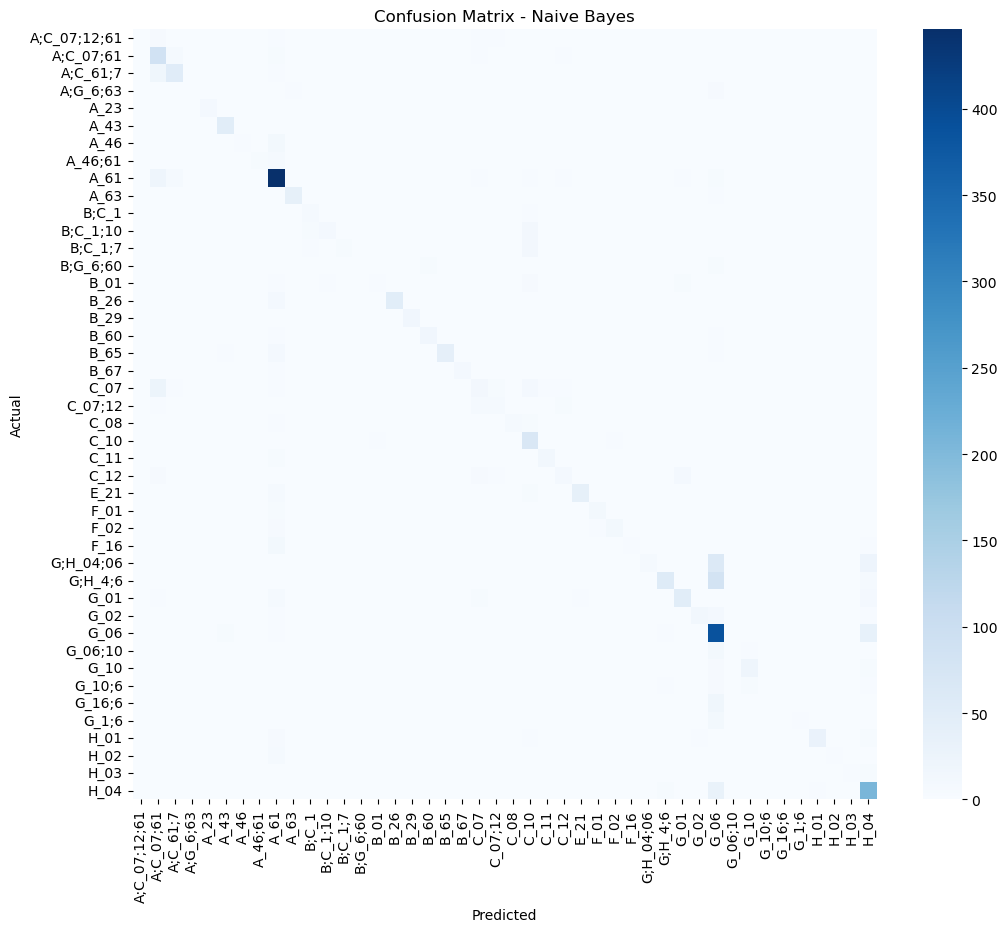

In [17]:
# Predictions
y_pred = class_model.predict(X_test_bayes)

# Confusion matrix
cm = confusion_matrix(y_test_bayes, y_pred, labels=class_model.classes_)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=class_model.classes_,
    yticklabels=class_model.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

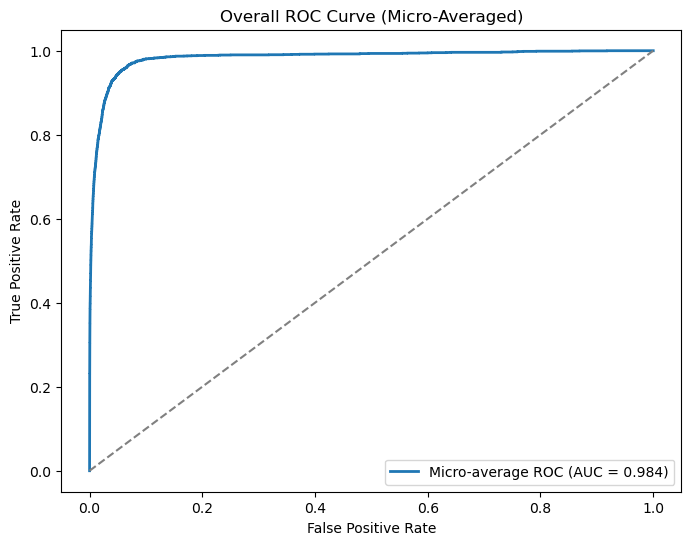

Overall AUC ROC: 0.9835539725057953


In [18]:
# Get the classes
classes = sorted(y_test_bayes.unique())

# Binarize true labels
y_test_bin = label_binarize(y_test_bayes, classes=classes)

# Predict probability estimates
y_proba = class_model.predict_proba(X_test_bayes)

# Compute micro-average ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"Micro-average ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve (Micro-Averaged)")
plt.legend()
plt.show()

print("Overall AUC ROC:", roc_auc)

## Train and Test a LinearSVC

In [19]:
# Define X and y
X_svc = df_subset["text_clean"]
y_svc = df_subset["Combined_ipc_clean"]

# Train/test split
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(
    X_svc, y_svc, test_size=0.2, stratify=y_svc, random_state=42
)

# LinearSVC model
model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english")),
        ("clf", LinearSVC(class_weight="balanced")),
    ]
)

# Fit model
model.fit(X_train_svc, y_train_svc)

# Predictions
y_pred = model.predict(X_test_svc)

# Evaluation
print("Accuracy:", accuracy_score(y_test_svc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_svc, y_pred))

Accuracy: 0.7537171178040412

Classification Report:
               precision    recall  f1-score   support

A;C_07;12;61       0.26      0.38      0.31        13
   A;C_07;61       0.64      0.74      0.69       103
    A;C_61;7       0.75      0.82      0.78        73
    A;G_6;63       1.00      0.64      0.78        11
        A_23       0.91      0.83      0.87        12
        A_43       0.89      0.96      0.92        51
        A_46       0.75      0.60      0.67        15
     A_46;61       0.44      0.79      0.56        14
        A_61       0.95      0.87      0.91       497
        A_63       0.89      0.91      0.90        44
       B;C_1       0.57      0.80      0.67        10
    B;C_1;10       0.61      0.54      0.57        26
     B;C_1;7       0.59      0.50      0.54        20
    B;G_6;60       0.44      0.40      0.42        10
        B_01       0.36      0.41      0.38        22
        B_26       0.88      0.97      0.92        58
        B_29       0.82    

## Visualize Results

So here we're going to use PCA to embed the text into 2d vectors, and them plot each cluster as a scatterplot. As there are too many classes to plot, we're going to first extract the section classification (alphabetical), and then indicate how many patents fell within a given letter. For example, after plotting, we see that the cluster for section A contains 833 unique patent classes.  

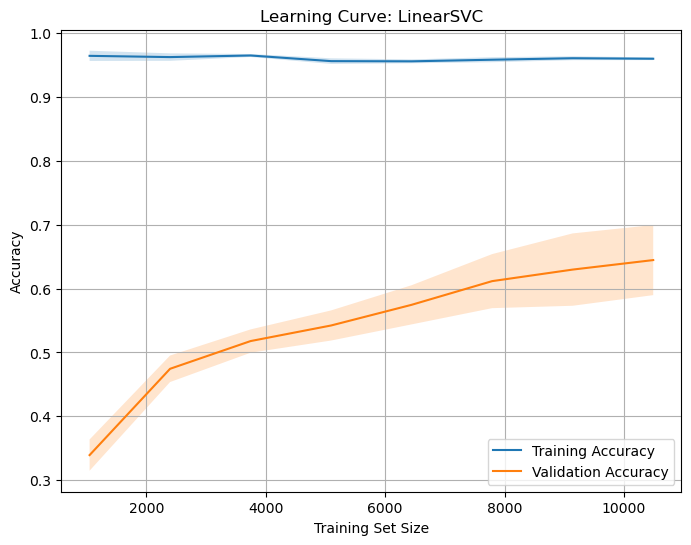

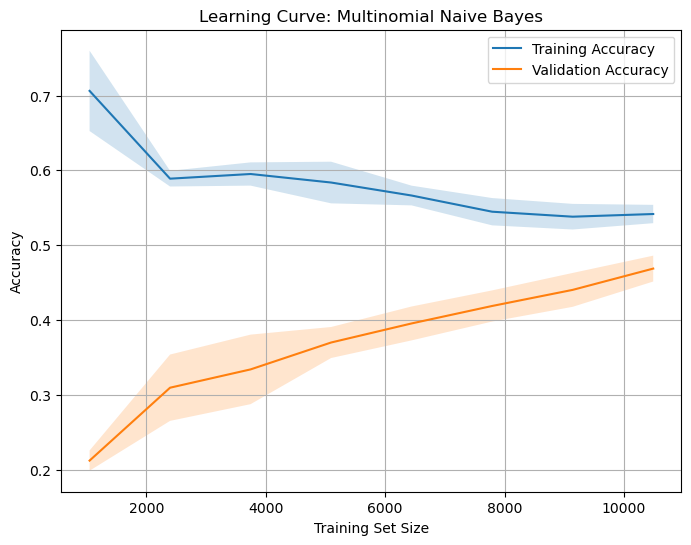

In [20]:
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np


def plot_learning_curve(estimator, title, X, y):
    plt.figure(figsize=(8, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8),
        scoring="accuracy",
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")

    # Train accuracy
    plt.plot(train_sizes, train_mean, label="Training Accuracy")
    plt.fill_between(
        train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2
    )

    # Validation accuracy
    plt.plot(train_sizes, test_mean, label="Validation Accuracy")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    plt.legend()
    plt.grid(True)
    plt.show()


# Create models
svc_model = Pipeline(
    [("tfidf", TfidfVectorizer(stop_words="english")), ("clf", LinearSVC())]
)

nb_model = Pipeline(
    [("tfidf", TfidfVectorizer(stop_words="english")), ("clf", MultinomialNB())]
)

# Plot learning curves
plot_learning_curve(svc_model, "Learning Curve: LinearSVC", X_svc, y_svc)
plot_learning_curve(nb_model, "Learning Curve: Multinomial Naive Bayes", X_svc, y_svc)

In [21]:
def normalize_ipc_label(label: str) -> str:
    # Handle composite labels (e.g., H;G:06) by taking the first section
    if ";" in label:
        label = label.split(";")[0]

    # Extract the IPC Section (A, B, C...)
    match = re.search(r"^[A-H]", label)  # IPC sections go from A to H
    if match:
        return match.group(0)

    return "UNKNOWN"


# Examples using the function:
# normalize_ipc_label('A_01')     # -> 'A'
# normalize_ipc_label('A:C:07')   # -> 'A'
# normalize_ipc_label('G;H:04')   # -> 'G' (first section)

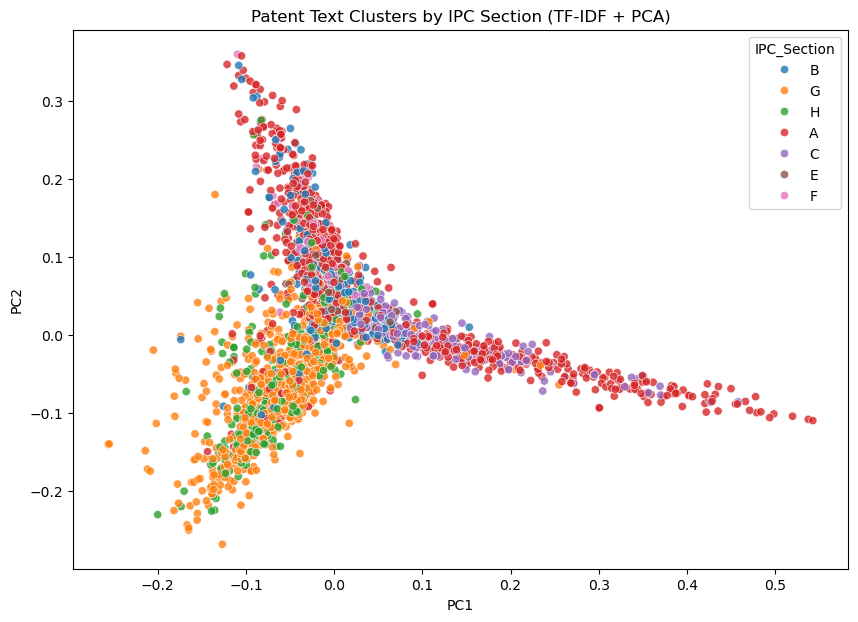

In [22]:
# Normalize the labels with the function above
y_sections = [normalize_ipc_label(lbl) for lbl in y_test_svc]

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X_test_svc)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_tfidf.toarray())

# Create DataFrame for plotting
pca_df = pd.DataFrame({"PC1": X_2d[:, 0], "PC2": X_2d[:, 1], "IPC_Section": y_sections})

# plot everything together first to see overall clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2", hue="IPC_Section", palette="tab10", alpha=0.8
)

plt.title("Patent Text Clusters by IPC Section (TF-IDF + PCA)")
plt.show()

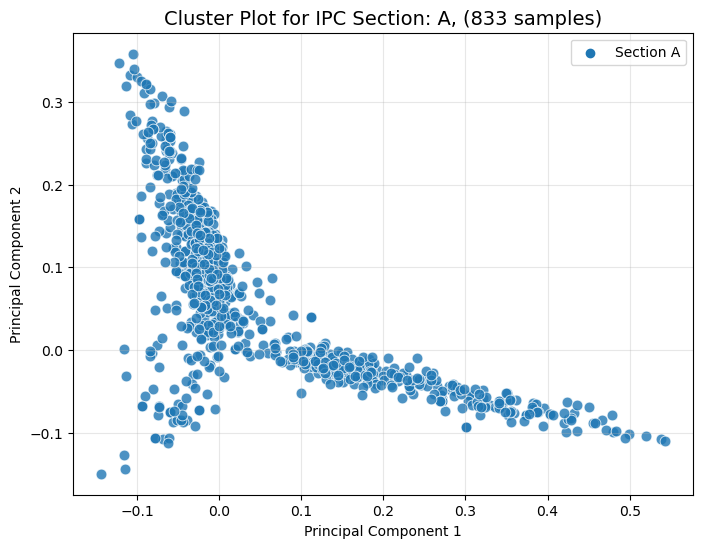

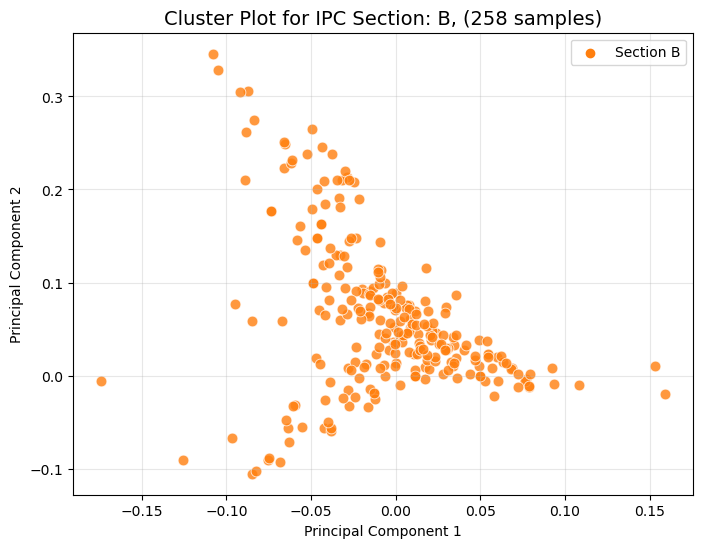

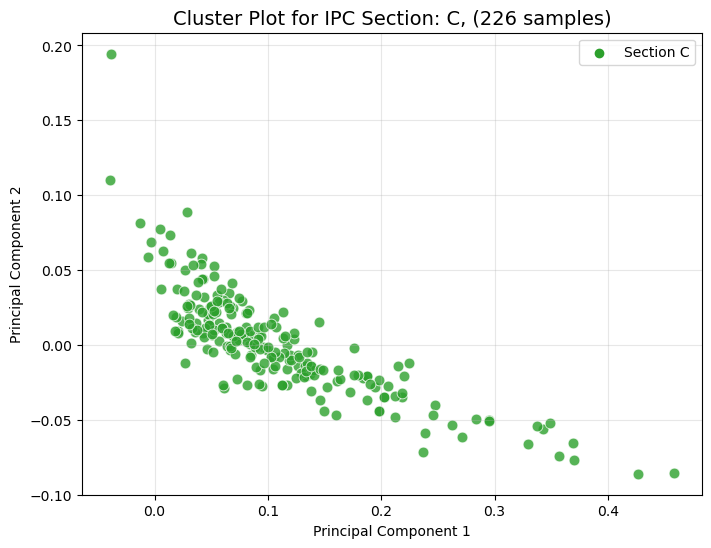

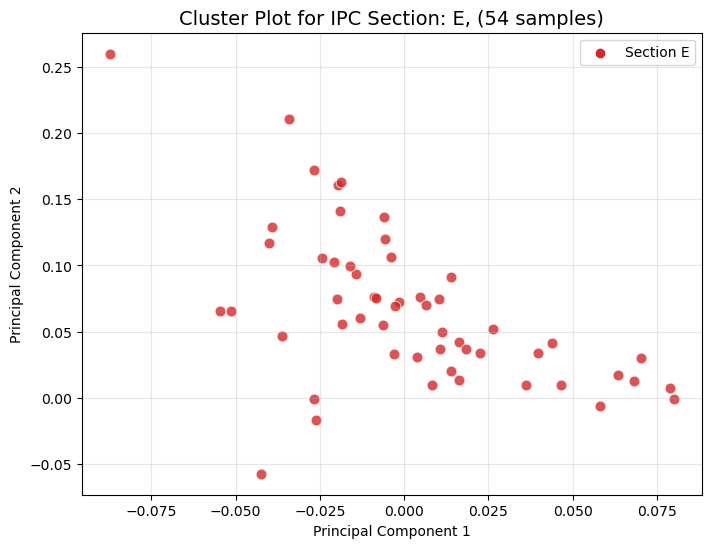

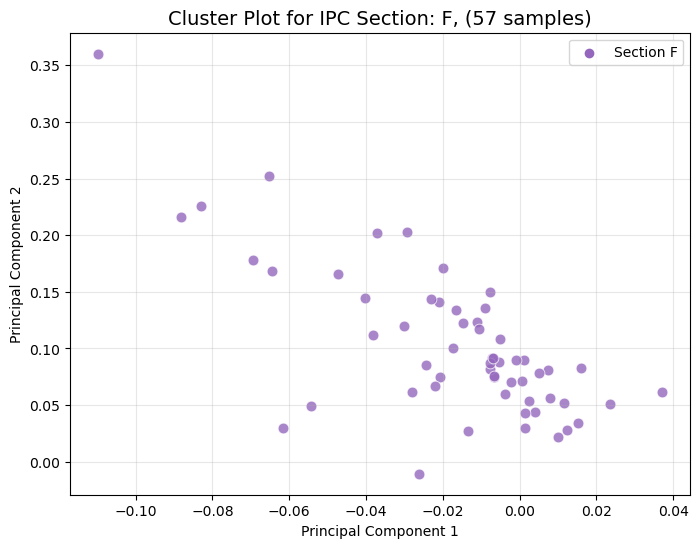

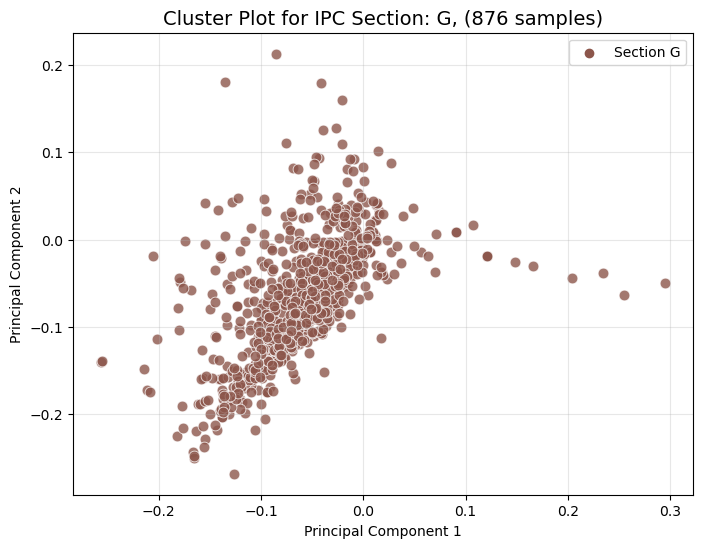

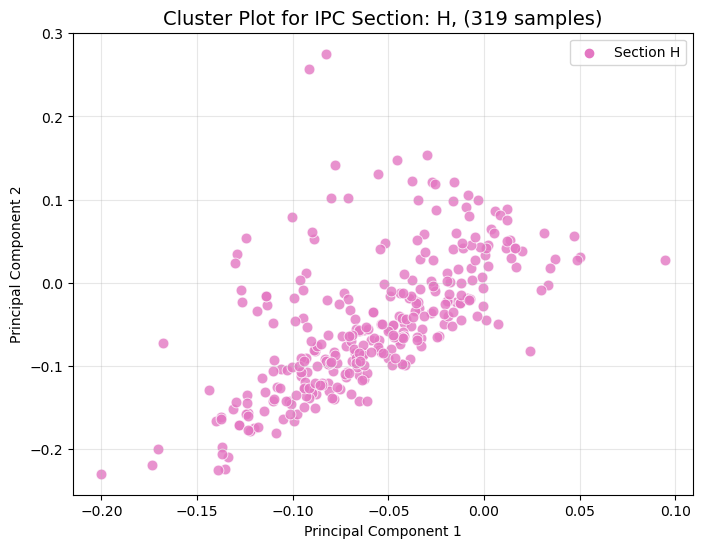

In [23]:
# now let's plot each section separately

unique_sections = sorted(pca_df["IPC_Section"].unique())
palette = sns.color_palette("tab10", len(unique_sections))
color_map = {sec: palette[i] for i, sec in enumerate(unique_sections)}

# 6. Plot each section separately using its assigned color
for section in unique_sections:
    pca_df_subset = pca_df[pca_df["IPC_Section"] == section]
    count = (pca_df_subset["IPC_Section"] == section).sum()
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=pca_df_subset, x="PC1", y="PC2", s=60, alpha=0.8, color=color_map[section]
    )

    plt.title(
        f"Cluster Plot for IPC Section: {section}, ({count} samples)",
        fontsize=14,
    )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)

    # Show legend with single color
    plt.scatter([], [], color=color_map[section], label=f"Section {section}")
    plt.legend()

    plt.show()

In [24]:
# Colors
palette = sns.color_palette("tab10", len(unique_sections))
color_map = {sec: palette[i] for i, sec in enumerate(unique_sections)}

# Shared axes limits
x_min, x_max = df["PC1"].min(), df["PC1"].max()
y_min, y_max = df["PC2"].min(), df["PC2"].max()

# Grid
n = len(unique_sections)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, section in enumerate(unique_sections):
    ax = axes[i]
    df_sub = df[df["Section"] == section]

    sns.scatterplot(
        data=df_sub, x="PC1", y="PC2", s=25, alpha=0.8, color=color_map[section], ax=ax
    )

    ax.set_title(
        f"IPC Section Label {section}, with ({len(df_sub)}) Unique Patents", fontsize=14
    )
    ax.grid(True, alpha=0.3)

    # Apply shared limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # ✅ Show ticks on all axes
    ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

KeyError: 'PC1'

In [ ]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()  # TF-IDF terms


def top_words_for_pc(pca, feature_names, pc_index, top_n=10):
    """
    Returns a DataFrame of the top_n words contributing to a given principal component.
    """
    pc_weights = pca.components_[pc_index]
    top_idx = np.argsort(pc_weights)[-top_n:][::-1]  # descending order
    top_words = feature_names[top_idx]
    top_values = pc_weights[top_idx]
    return pd.DataFrame({"Word": top_words, "Weight": top_values})


# Top 10 words for PC1
df_pc1 = top_words_for_pc(pca, feature_names, pc_index=0)
# Top 10 words for PC2
df_pc2 = top_words_for_pc(pca, feature_names, pc_index=1)

# print("Top 10 words contributing to PC1:")
# print(df_pc1)
# print("\nTop 10 words contributing to PC2:")
# print(df_pc2)

df_top = pd.DataFrame(
    {
        "PC1_Word": df_pc1["Word"],
        "PC1_Weight": df_pc1["Weight"],
        "PC2_Word": df_pc2["Word"],
        "PC2_Weight": df_pc2["Weight"],
    }
)

print(df_top)

      PC1_Word  PC1_Weight  PC2_Word  PC2_Weight
0     compound    0.378875     first    0.265404
1  composition    0.219897    second    0.226506
2     receptor    0.203563       end    0.201733
3      disease    0.184532    member    0.172338
4    invention    0.168484   portion    0.149515
5      formula    0.161537   surface    0.135541
6    treatment    0.159932  assembly    0.130970
7       useful    0.144277      body    0.118276
8         salt    0.122672     fluid    0.102165
9    inhibitor    0.117790    distal    0.096914
